# Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [2]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [ ]:
import numpy as np
import torch

# Define the target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Filter out non-trajectory keys
trajectories = {key: value for key, value in kuka_data.items() if key.startswith('kukatraj')}
trajectory_keys = sorted(list(trajectories.keys()))

# Optimisation
---

In [ ]:
import time
import optuna
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneOut
import sys
sys.path.append('models')

import lstm_model

N_TRIALS = 13
optimisation_start_time = time.time()

def objective(trial):
    """
    The objective function for Optuna to optimize for the LSTM.
    """
    # 1. Suggest hyperparameters
    params = {
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'hidden_size': trial.suggest_int('hidden_size', 60, 600),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1e-2, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.8),
        'sequence_length': trial.suggest_int('sequence_length', 10, 80),
        'epochs': trial.suggest_int('epochs', 20, 150),
    }

    # Define data splits for optimization
    train_val_keys = [f'kukatraj{i}' for i in range(1, 6)]
    train_val_list = [trajectories[key] for key in train_val_keys]
    # full_train_data = np.concatenate(train_val_list, axis=0)  # No longer needed here
    # X_train_full, y_train_full = full_train_data[:, :21], full_train_data[:, 21:]  # Remove this

    # 2. Perform Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    fold_errors = []

    # Fix the loop with enumerate and correct data selection
    for fold, (train_traj_idx, val_traj_idx) in enumerate(loo.split(range(len(train_val_keys)))):
        # Select training trajectories and concatenate them
        train_traj_list = [train_val_list[i] for i in train_traj_idx]
        train_data = np.concatenate(train_traj_list, axis=0)
        X_train_fold, y_train_fold = train_data[:, :21], train_data[:, 21:]

        # Select validation trajectory (val_traj_idx is an array with one element)
        val_data = train_val_list[val_traj_idx[0]]
        X_val_fold, y_val_fold = val_data[:, :21], val_data[:, 21:]

        # Create sequences for training
        X_train_seq, y_train_seq = lstm_model.create_sequences(X_train_fold, y_train_fold, params['sequence_length'])
        
        # Convert to Tensors
        X_train_t = torch.from_numpy(X_train_seq).float().to(device)
        y_train_t = torch.from_numpy(y_train_seq).float().to(device)
        X_val_t = torch.from_numpy(X_val_fold).float().to(device)

        # Create DataLoader
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=256, num_workers=0, shuffle=True)

        # Instantiate and train the model
        model = lstm_model.LSTMModel(
            input_size=21,
            output_size=14,
            hidden_size=params['hidden_size'],
            num_layers=params['n_layers'],
            dropout_rate=params['dropout']
        ).to(device)

        model = lstm_model.train_lstm_model(model, train_loader, params['learning_rate'], params['epochs'])

        # Predict and calculate error
        predictions = lstm_model.predict_full_trajectory_lstm(model, X_val_t, params['sequence_length'])
        
        # Calculate nMSE (Normalized Mean Squared Error)
        true_values = y_val_fold
        predictions_aligned = predictions[params['sequence_length']-1:]
        true_values_aligned = true_values[params['sequence_length']-1:]

        error = np.mean((predictions_aligned - true_values_aligned)**2)
        variance = np.var(true_values_aligned)
        nMSE = error / (variance + 1e-9)
        fold_errors.append(nMSE)

    average_nMSE = np.mean(fold_errors)
    return average_nMSE

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS) # n_trials can be adjusted

[I 2025-07-16 12:10:46,082] A new study created in memory with name: no-name-2738eef6-c109-4015-a527-43b14db8fa07
/tmp/ipykernel_19/2058744688.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_19/2058744688.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-07-16 12:13:21,363] Trial 0 finished with value: 1.0009068703051107 and parameters: {'n_layers': 3, 'hidden_size': 175, 'learning_rate': 3.4410533976261055e-08, 'dropout': 0.7428234431731585, 'sequence_length': 24, 'epochs': 28}. Best is trial 0 with value: 1.0009068703051107.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13587048952483183

In [9]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.005812866108646305
  Params: 
    n_layers: 1
    hidden_size: 503
    learning_rate: 0.0007774687445330236
    dropout: 0.394187055296344
    sequence_length: 65
    epochs: 75


/tmp/ipykernel_19/1799482134.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

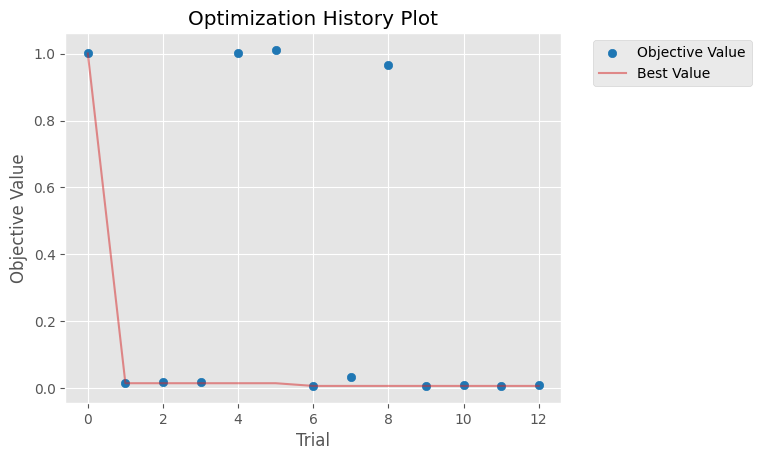

In [10]:
import optuna.visualization.matplotlib as opplt
opplt.plot_optimization_history(study)

/tmp/ipykernel_19/2166294799.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

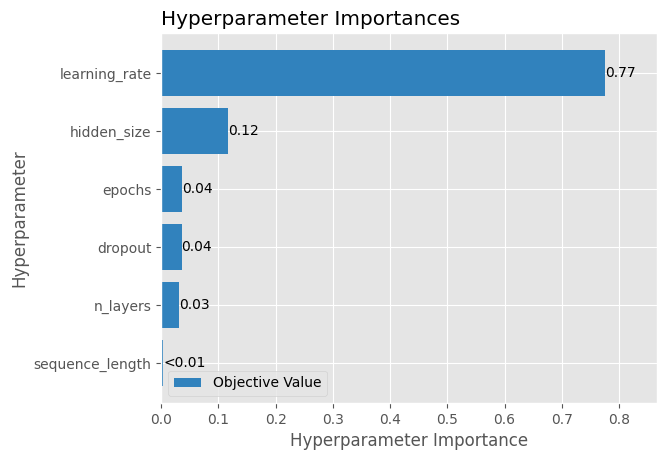

In [11]:
opplt.plot_param_importances(study)

/tmp/ipykernel_19/1591831254.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_slice(study, params=['dropout', 'sequence_length', 'hidden_size', 'learning_rate', 'epochs', 'n_layers'])


array([<Axes: xlabel='dropout', ylabel='Objective Value'>,
       <Axes: xlabel='epochs'>, <Axes: xlabel='hidden_size'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='n_layers'>,
       <Axes: xlabel='sequence_length'>], dtype=object)

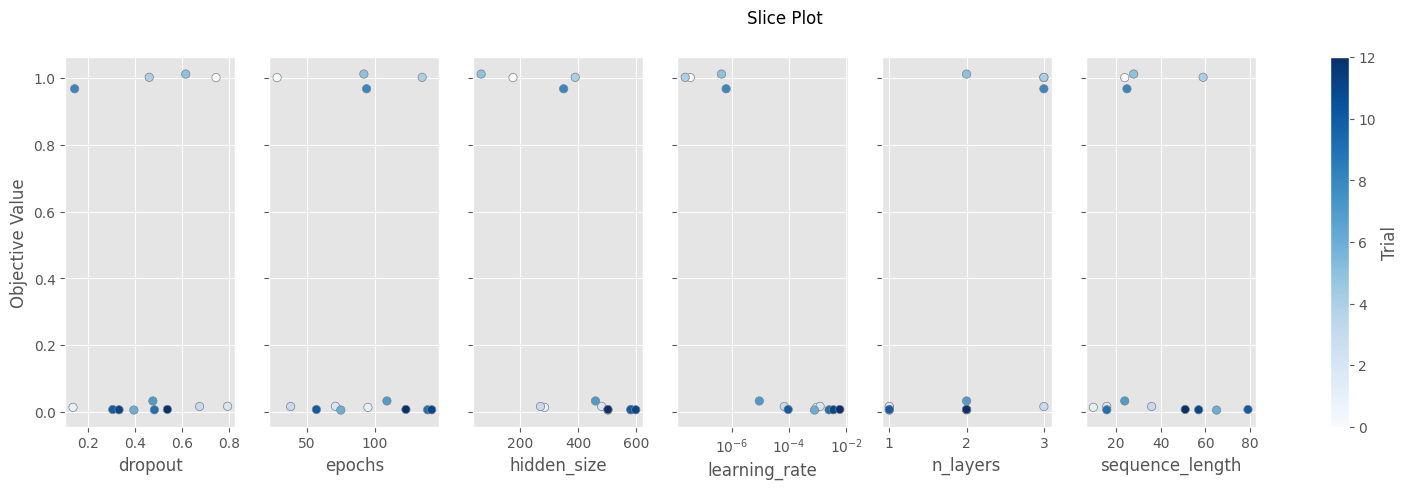

In [12]:
opplt.plot_slice(study, params=['dropout', 'sequence_length', 'hidden_size', 'learning_rate', 'epochs', 'n_layers'])